In [ ]:
load(file="finalproject.Rdata")
ls()

[1] "df"            "finalPro_data" "fit"           "m"            
[5] "models"        "results"       "ts_data"       "ts_gdp"

In [ ]:
df = finalPro_data
print(df, n=58)

# A tibble: 58 × 9
   Country          Code   Year    GDP   Growth   CPI Imports Exports Population
   <fct>            <fct> <dbl>  <dbl>    <dbl> <dbl>   <dbl>   <dbl>      <dbl>
 1 Central African… CAF    1960 1.12e8 NA        NA      34.2    23.3    1503508
 2 Central African… CAF    1961 1.23e8  4.95e+0  NA      35.8    26.5    1529227
 3 Central African… CAF    1962 1.24e8 -3.71e+0  NA      37.7    24.6    1556661
 4 Central African… CAF    1963 1.29e8 -7.07e-1  NA      38.5    25.2    1585763
 5 Central African… CAF    1964 1.42e8  2.08e+0  NA      40.8    28.4    1616516
 6 Central African… CAF    1965 1.51e8  9.48e-1  NA      37.7    27.1    1648833
 7 Central African… CAF    1966 1.58e8  6.45e-1  NA      42.5    28.4    1682885
 8 Central African… CAF    1967 1.64e8  4.68e+0  NA      46.9    26.3    1718603
 9 Central African… CAF    1968 1.92e8  1.40e+0  NA      39.6    34.3    1755344
10 Central African… CAF    1969 1.88e8  7.09e+0  NA      37.6    27.3    1792220
11 Centra

In [ ]:
library(tseries)
library(dplyr)
library(purrr)
library(forecast)

In [ ]:
ts_gdp <- ts(diff(log(df$GDP)),
             start = min(df$Year) + 1,
             frequency = 1)

# comparing MA(q = 1,2), ARMA(1,1), and ARIMA(0,1,1)
models <- list(
  list(name = "MA(1)", order = c(0,0,1)),
  list(name = "MA(2)", order = c(0,0,2)),
  list(name = "ARMA(1,1)", order = c(1,0,1)),
  list(name = "ARIMA(0,1,1)", order = c(0,1,1)))

  results <- list()

In [ ]:
AICc_manual <- function(fit) {
  n <- length(residuals(fit))
  K <- length(fit$coef) + 1
  aic <- AIC(fit)
  aic + (2 * K * (K + 1)) / (n - K - 1)
}

In [ ]:
cmp <- map_df(results, ~{
  fit <- .
  tibble(
    Model = paste(fit$model$order, collapse = ","),
    AIC = AIC(fit),
    AICc = AICc_manual(fit),
    BIC = BIC(fit),
    LB10 = Box.test(residuals(fit), lag = 10, type = "Ljung-Box")$p.value,
    LB20 = Box.test(residuals(fit), lag = 20, type = "Ljung-Box")$p.value
  )
}, .id = "Name")

print(cmp)
print(results)

# A tibble: 4 × 7
  Name         Model   AIC  AICc   BIC  LB10  LB20
  <chr>        <chr> <dbl> <dbl> <dbl> <dbl> <dbl>
1 MA(1)        ""    -61.2 -61.0 -57.1 0.862 0.816
2 MA(2)        ""    -60.5 -60.0 -54.4 0.853 0.841
3 ARMA(1,1)    ""    -63.4 -62.9 -57.3 0.881 0.900
4 ARIMA(0,1,1) ""    -62.2 -62.0 -58.1 0.879 0.881
$`MA(1)`
Series: ts_gdp 
ARIMA(0,0,1) with zero mean 

Coefficients:
         ma1
      0.1267
s.e.  0.1182

sigma^2 = 0.01897:  log likelihood = 32.61
AIC=-61.22   AICc=-61   BIC=-57.13

$`MA(2)`
Series: ts_gdp 
ARIMA(0,0,2) with zero mean 

Coefficients:
         ma1     ma2
      0.0827  0.1508
s.e.  0.1416  0.1327

sigma^2 = 0.01888:  log likelihood = 33.24
AIC=-60.48   AICc=-60.03   BIC=-54.35

$`ARMA(1,1)`
Series: ts_gdp 
ARIMA(1,0,1) with zero mean 

Coefficients:
         ar1      ma1
      0.9786  -0.9133
s.e.  0.0852   0.1926

sigma^2 = 0.01781:  log likelihood = 34.7
AIC=-63.39   AICc=-62.94   BIC=-57.26

$`ARIMA(0,1,1)`
Series: ts_gdp 
ARIMA(0,1,1) 

Coeff

In [ ]:
install.packages("car")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘rbibutils’, ‘cowplot’, ‘Deriv’, ‘microbenchmark’, ‘Rdpack’, ‘numDeriv’, ‘doBy’, ‘SparseM’, ‘MatrixModels’, ‘minqa’, ‘nloptr’, ‘reformulas’, ‘RcppEigen’, ‘carData’, ‘abind’, ‘Formula’, ‘pbkrtest’, ‘quantreg’, ‘lme4’




Loading required package: carData


Attaching package: ‘car’


The following object is masked from ‘package:purrr’:

    some


The following object is masked from ‘package:dplyr’:

    recode




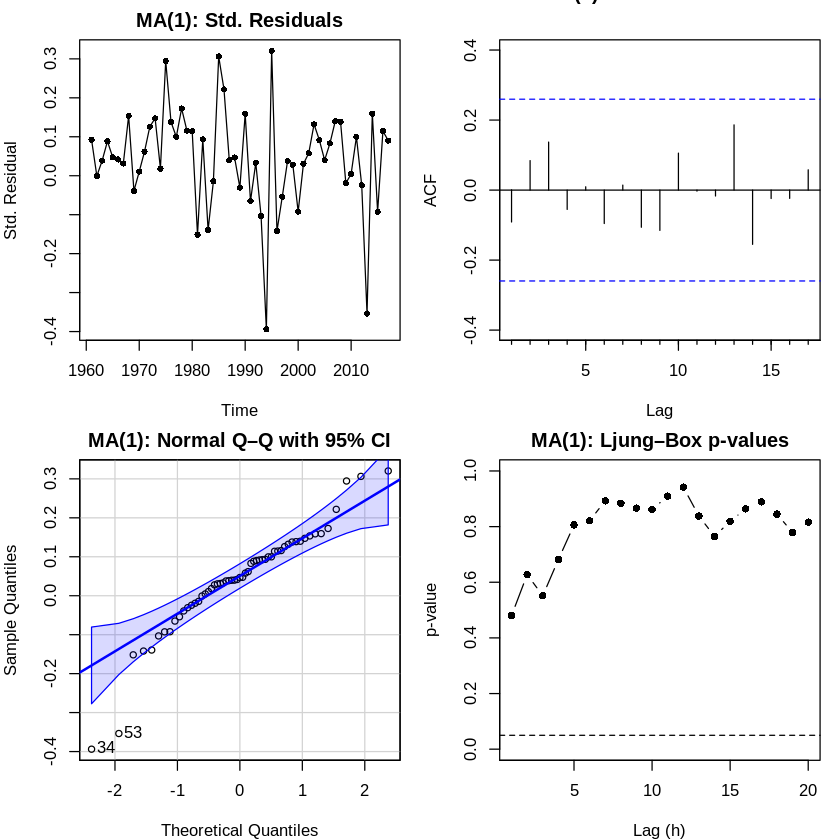

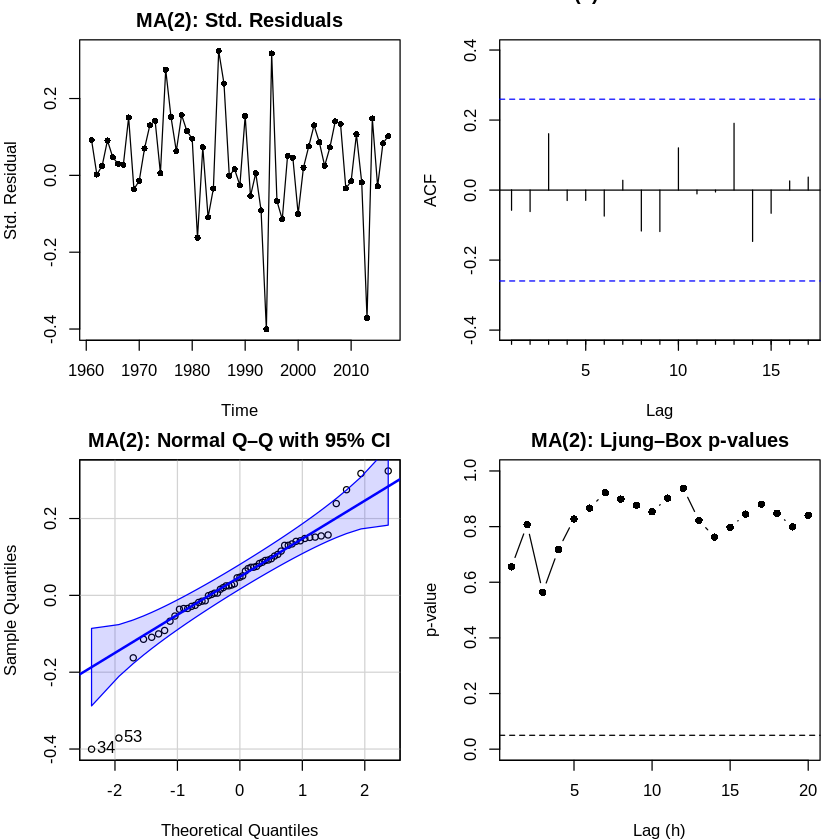

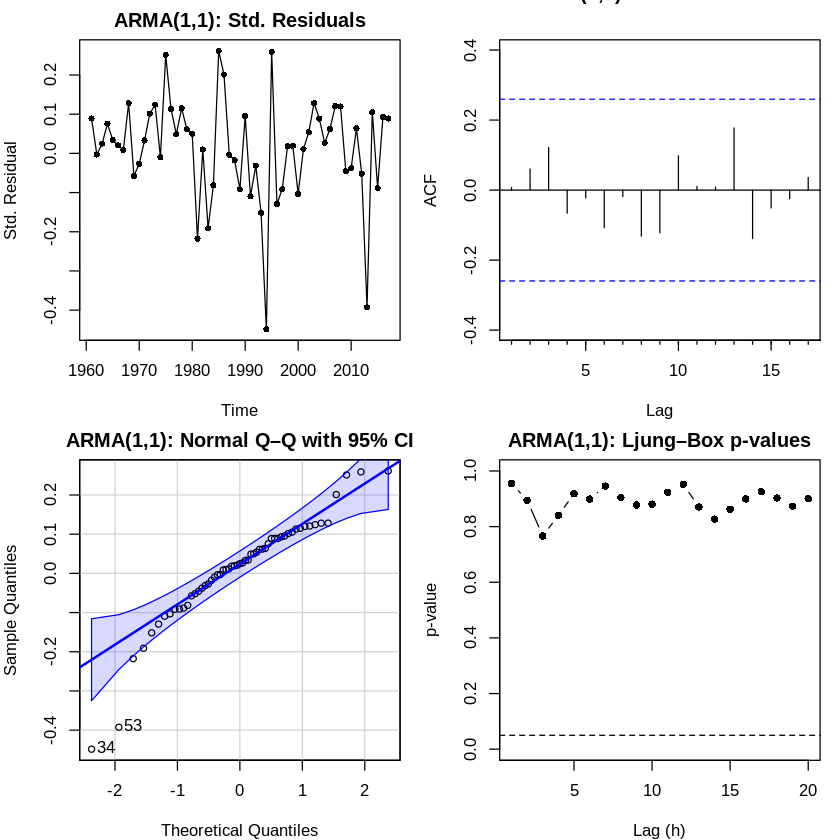

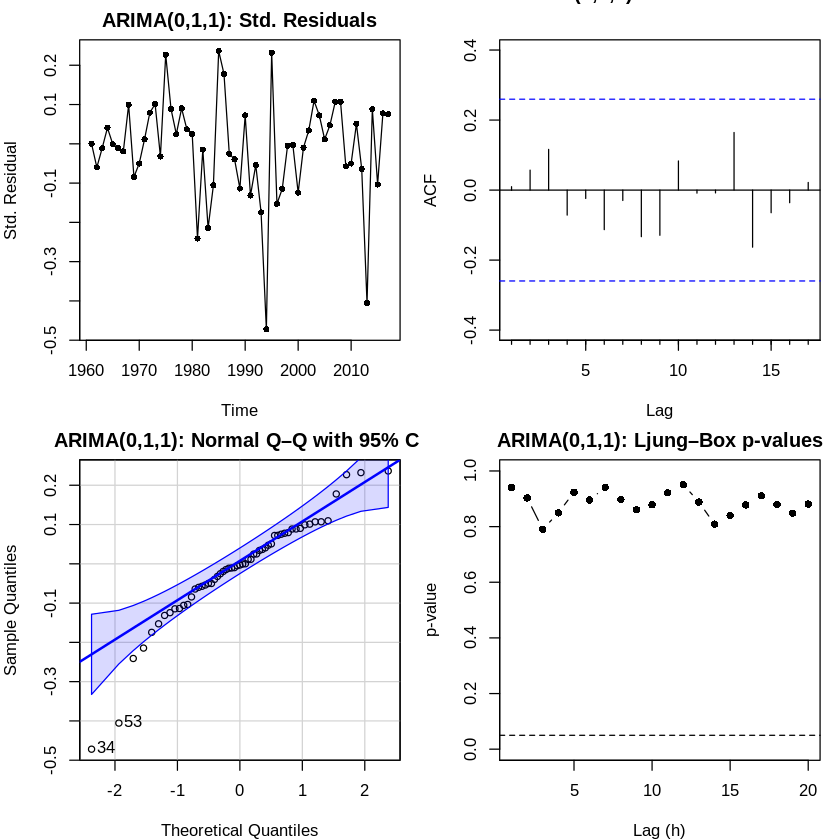

In [ ]:
library(forecast)
library(tseries)
library(car)

# loop over each model
for(model_name in names(results)) {
  fit <- results[[model_name]]

  # standardized residuals
  res_std <- residuals(fit, standardize = TRUE)

  # compute LB p-values for lags 1:20
  lags  <- 1:20
  pvals <- sapply(lags, function(h)
    Box.test(res_std, lag = h, type = "Ljung-Box")$p.value
  )

  # create 2×2 plotting area
  par(mfrow = c(2,2), mar = c(4,4,2,1))

  # time‐series of standardized residuals
  plot(res_std,
       main = paste0(model_name, ": Std. Residuals"),
       ylab = "Std. Residual",
       xlab = "Time",
       type = "o", pch = 16)

  # ACF of residuals
  Acf(res_std,
      main = paste0(model_name, ": ACF of Residuals"))

  # QQ-plot with 95% envelope
  qqPlot(res_std,
         main = paste0(model_name, ": Normal Q–Q with 95% CI"),
         envelope = 0.95,
         xlab = "Theoretical Quantiles",
         ylab = "Sample Quantiles")

  # Ljung–Box p-values plot
  plot(lags, pvals,
       type = "b", pch = 16,
       xaxt = "n",
       ylim = c(0,1),
       main = paste0(model_name, ": Ljung–Box p-values"),
       xlab = "Lag (h)",
       ylab = "p-value")
  axis(1, at = seq(0,20,5), labels = seq(0,20,5))
  abline(h = 0.05, lty = 2)
}


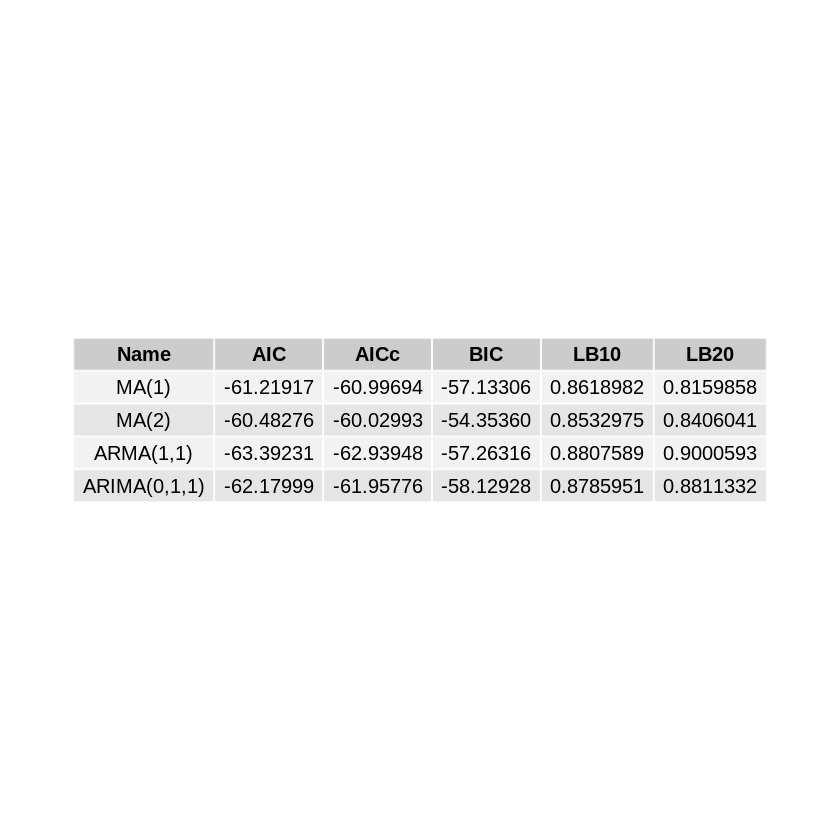

In [ ]:
library(gridExtra)
library(grid)

cmp_dropped = cmp %>% select(-Model)

tbl = tableGrob(cmp_dropped, rows = NULL)

grid.newpage()
grid.draw(tbl)